In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

data_input = {}
# 경로 나중에 바꿔야 된다. 
import os
for dirname, _, filenames in os.walk('./kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        data_input[filename] = pd.read_csv(os.path.join(dirname, filename))
print(data_input)

{'sales_train.csv':                date  date_block_num  shop_id  item_id  item_price  \
0        02.01.2013               0       59    22154      999.00   
1        03.01.2013               0       25     2552      899.00   
2        05.01.2013               0       25     2552      899.00   
3        06.01.2013               0       25     2554     1709.05   
4        15.01.2013               0       25     2555     1099.00   
...             ...             ...      ...      ...         ...   
2935844  10.10.2015              33       25     7409      299.00   
2935845  09.10.2015              33       25     7460      299.00   
2935846  14.10.2015              33       25     7459      349.00   
2935847  22.10.2015              33       25     7440      299.00   
2935848  03.10.2015              33       25     7460      299.00   

         item_cnt_day  
0                 1.0  
1                 1.0  
2                -1.0  
3                 1.0  
4                 1.0  
...    

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [14]:
train_data_origin = data_input['sales_train.csv']
item_categories_origin = data_input['item_categories.csv']
shop_origin = data_input['shops.csv']
items_origin = data_input['items.csv']
test_data_origin = data_input['test.csv']
del data_input['sample_submission.csv']

In [15]:
del data_input

In [16]:
train_data = pd.DataFrame(train_data_origin)

In [19]:
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [30]:
anomal_count = train_data['item_cnt_day'].map(lambda x : x < 0.0)
anomal_count = train_data[anomal_count]
print(anomal_count)

               date  date_block_num  shop_id  item_id  item_price  \
2        05.01.2013               0       25     2552       899.0   
148      23.01.2013               0       25     2321       999.0   
175      07.01.2013               0       25     2199      1449.0   
807      02.01.2013               0       25     2330       599.0   
1041     13.01.2013               0       25     5034      1989.0   
...             ...             ...      ...      ...         ...   
2934243  26.10.2015              33       25     3917       449.0   
2934462  18.10.2015              33       25     4896      6398.0   
2935263  05.10.2015              33       25    10039       249.0   
2935643  16.10.2015              33       25     7893      2990.0   
2935779  07.10.2015              33       25     7087       999.0   

         item_cnt_day  
2                -1.0  
148              -1.0  
175              -1.0  
807              -1.0  
1041             -1.0  
...               ...  
293

0 0 1
0 1 2
1 0 3
1 1 4
2 0 5
2 1 6


IndexError: index 6 is out of bounds for axis 0 with size 6

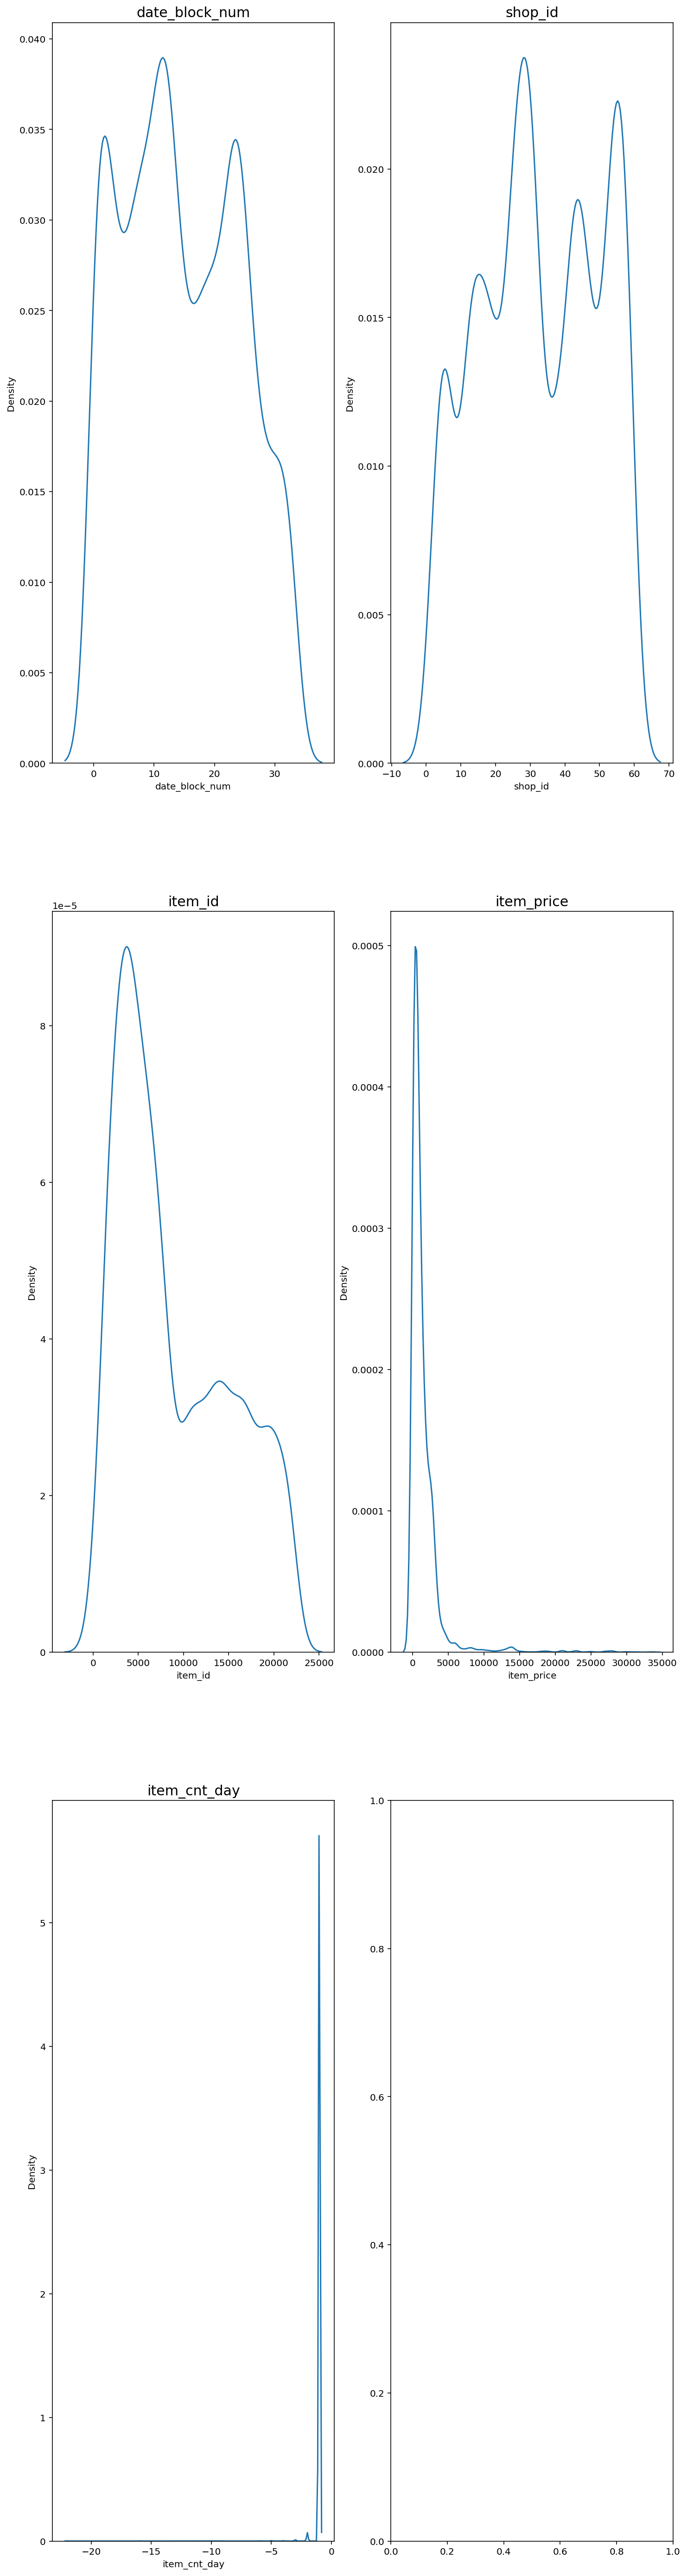

In [38]:
fig, ax = plt.subplots(3,2,figsize = (12,50))

count = 1
for row in range(3) :
    for col in range(2) :
        print(row,col,count)
        sns.kdeplot(anomal_count[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 6 :
            break

하루 판매량이 -인 값들을 모아서 혹시 각 값 간의 상관관계(ex: 특정 품목에서 유독 하루 매출량 에러가 난다거나)가 있는지 살펴봤는데, 특정 item id에 살짝 몰려 있는 것과, 하루 판매량이 -1부터 -5정도까지 다양하게 존재한다는 것을 알게 되었다. 첫번째로는 어떤 item id에서 판매량이 오류가 났는지 좀 더 살펴볼 예정이고, 두번째로는 결측치나 마찬가지인 이상값이 아닌 왠지 입력과정에서 부호가 뒤바뀌어서 들어갔을 가능성을 생각할 수 있게 되었다. 그래서 다음과 같은 작업을 해보려고 한다. 
1. 어떤 상품에서 하루 판매량 오류가 가장 많이 일어났나
2. 1이 파악된 후에 이상치의 부호를 바로잡아 정상값으로 되돌리자.

In [64]:
print(anomal_count.groupby('item_cnt_day').count().sort_values(['item_cnt_day'],ascending=False))
anomal_item = anomal_count.groupby('item_id').count().sort_values(['date'], ascending=False)
print(anomal_item)


              date  date_block_num  shop_id  item_id  item_price
item_cnt_day                                                    
-1.0          7252            7252     7252     7252        7252
-2.0            78              78       78       78          78
-3.0            14              14       14       14          14
-4.0             3               3        3        3           3
-5.0             4               4        4        4           4
-6.0             2               2        2        2           2
-9.0             1               1        1        1           1
-16.0            1               1        1        1           1
-22.0            1               1        1        1           1
         date  date_block_num  shop_id  item_price  item_cnt_day
item_id                                                         
2331       56              56       56          56            56
3734       41              41       41          41            41
1915       32            

0 0 1
0 1 2
1 0 3
1 1 4
2 0 5


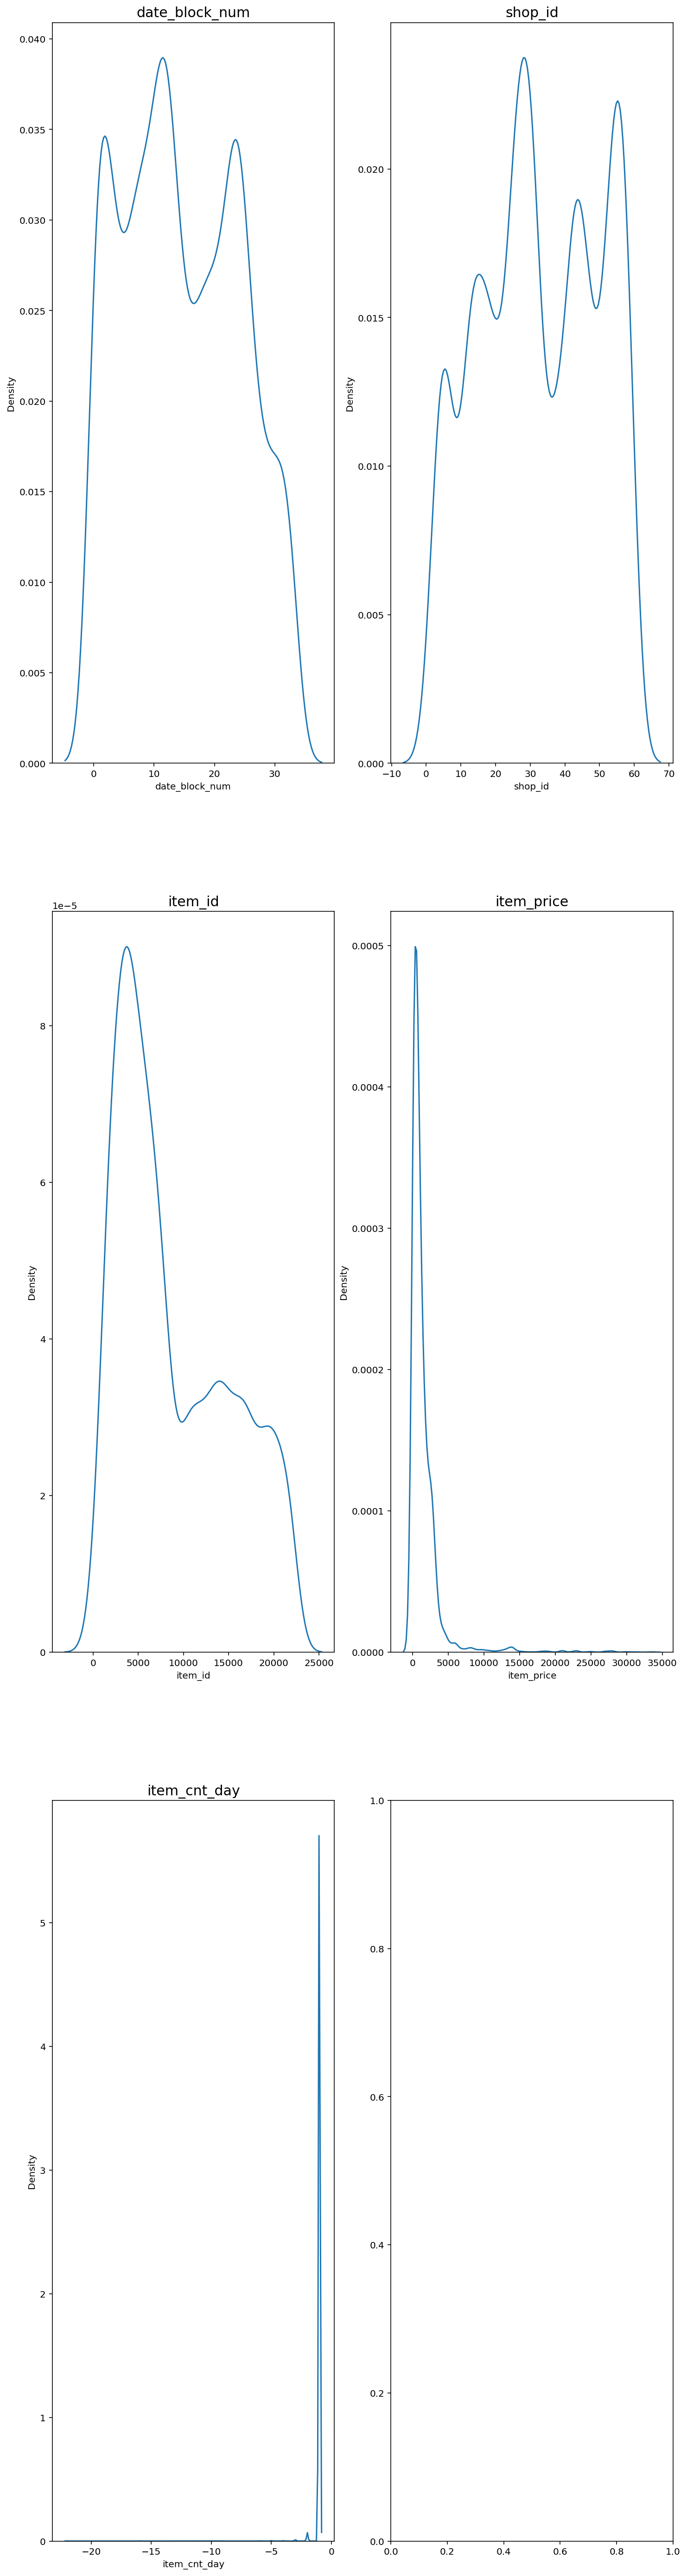

In [53]:
fig, ax = plt.subplots(3,2,figsize = (12,50))

count = 1
for row in range(3) :
    for col in range(2) :
        sns.kdeplot(anomal_count[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 6 :
            break

In [68]:
print(anomal_item.describe())
anomal_item_over_75 = anomal_item[anomal_item.apply(lambda x : x['date'] > 2, axis = 1)]

              date  date_block_num      shop_id   item_price  item_cnt_day
count  3511.000000     3511.000000  3511.000000  3511.000000   3511.000000
mean      2.095130        2.095130     2.095130     2.095130      2.095130
std       2.780899        2.780899     2.780899     2.780899      2.780899
min       1.000000        1.000000     1.000000     1.000000      1.000000
25%       1.000000        1.000000     1.000000     1.000000      1.000000
50%       1.000000        1.000000     1.000000     1.000000      1.000000
75%       2.000000        2.000000     2.000000     2.000000      2.000000
max      56.000000       56.000000    56.000000    56.000000     56.000000
             date  date_block_num     shop_id  item_price  item_cnt_day
count  685.000000      685.000000  685.000000  685.000000    685.000000
mean     5.709489        5.709489    5.709489    5.709489      5.709489
std      4.766965        4.766965    4.766965    4.766965      4.766965
min      3.000000        3.000000    

이렇게 '판매량'에 대한 '마이너스'로 이상치를 가지고 있는 데이터들의 분석을 해보았다. 그런데 중복적으로 이상치가 들어오는 아이디는 따로 분류할 필요가 있어보인다. 상위 75퍼센트의 값을 모아서 확인해보니 4번 이상 마이너스값을 가진 아이디들을 따로 뽑아서 후에 데이터 분석에 활용할 예정이다. 

In [80]:
anomal_item_id_list = anomal_item[anomal_item.apply(lambda x : x['date'] > 3, axis = 1)]
print(anomal_item_id_list)
#anomal_item_id_list = anomal_item_id_list['item_id']
print(anomal_item_id_list.describe())
anomal_item_id_list = anomal_item_id_list.index
anomal_item_id_list = anomal_item_id_list.drop_duplicates()

         date  date_block_num  shop_id  item_price  item_cnt_day
item_id                                                         
2331       56              56       56          56            56
3734       41              41       41          41            41
1915       32              32       32          32            32
5672       31              31       31          31            31
16787      27              27       27          27            27
...       ...             ...      ...         ...           ...
11497       4               4        4           4             4
18168       4               4        4           4             4
3738        4               4        4           4             4
18344       4               4        4           4             4
7806        4               4        4           4             4

[422 rows x 5 columns]
             date  date_block_num     shop_id  item_price  item_cnt_day
count  422.000000      422.000000  422.000000  422.000000  

이제 마이너스로 나온 판매량을 양의 값으로 보정할 때가 왔다. 

In [83]:
train_data['item_cnt_day'] = train_data['item_cnt_day'].apply(lambda x : abs(x))
print(len(train_data[train_data['item_cnt_day'].apply(lambda x : x < 0)]))

0


일단 데이터에 대해서 아무것도 모른다고 치고 데이터의 분포부터 알아보자. 